# Quantitative Metrics of Time-Series Benchmark

## Data Extraction / Preparation

In [37]:
import wandb

# Initialize API (make sure you're logged in or set the API key)
wandb.login()

# Replace with your entity, project, and run ID
api = wandb.Api()

# Get all runs of the project that didn't crash
runs = api.runs(
    "rl-sunflower/tabpfn-time-series",
    # filters={"$and": [{"state": "finished"}, {"group": {"$in": ["11546127", "11548929"]}}]}
    filters={"tags": {"$in": [
        # Seasonal Naive
        "baseline-seasonal-naive",

        # Vanilla TabPFN
        "naive-tabpfn",

        # Autogluon (without Chronos)
        "baseline-autogluon-no-chronos",     
    ]}},   
)


In [38]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd

def fetch_run_data(run):
    history = run.history()
    
    if len(history) > 1:
        # get the first row
        history = history.iloc[-1:]
    return history

# time the following code
import time
start = time.time()

all_runs_data = []
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust 'max_workers' based on your network conditions
    futures = [executor.submit(fetch_run_data, run) for run in runs]
    for future in tqdm(as_completed(futures), total=len(futures)):
        all_runs_data.append(future.result())

df_all_runs = pd.concat(all_runs_data)
print("df_all_runs.shape:", df_all_runs.shape)

print(f"Time taken: {time.time() - start:.2f} seconds")


100%|██████████| 75/75 [00:03<00:00, 20.89it/s]


df_all_runs.shape: (75, 27)
Time taken: 4.35 seconds


In [39]:
# Preprocess data (convert to float, NaN value -> inf)
numerical_cols = ['mase', 'wql', 'duration', 'result']
for col in numerical_cols:
    df_all_runs[col] = df_all_runs[col].astype(float)
    # df_all_runs[col] = df_all_runs[col].fillna(float('inf')).replace([float('inf'), np.nan], np.nan).astype(float)


# Get relevant columns only
df_all_runs = df_all_runs[['framework', 'task', 'mase', 'wql', 'duration']]
# df_rel = df_rel.drop_duplicates(subset=["framework", "task"], keep='first')

# Sort by framework and task
df_all_runs = df_all_runs.sort_values(by=['framework', 'task'])

# Drop index
df_all_runs.reset_index(drop=True, inplace=True)

In [40]:
print(df_all_runs.to_string())


        framework                task      mase       wql  duration
0       AutoGluon           car_parts  0.747569  0.979598     986.0
1       AutoGluon            cif_2016  0.946028  0.038041     568.3
2       AutoGluon        covid_deaths  5.851320  0.030816     715.5
3       AutoGluon  electricity_hourly  0.955928  0.093517    2939.8
4       AutoGluon  electricity_weekly  2.060200  0.112114     573.2
5       AutoGluon             fred_md  0.579001  0.047529     772.6
6       AutoGluon            hospital  0.750466  0.053791     755.5
7       AutoGluon        kdd_cup_2018  0.772941  0.339020    2925.2
8       AutoGluon          m1_monthly  1.000710  0.140262     669.5
9       AutoGluon        m1_quarterly  1.603630  0.076366     514.7
10      AutoGluon           m1_yearly  3.543180  0.129233     654.0
11      AutoGluon          m3_monthly  0.822336  0.094369     977.6
12      AutoGluon            m3_other  1.893090  0.031218     611.2
13      AutoGluon        m3_quarterly  1.080660 

## Plotting

### Utils Function

In [41]:
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data, title, xlabel, ylabel, annot_format=".0f", cmap='YlOrRd', annot=None):
    """
    Plots a heatmap for given data.

    Parameters:
    - data: DataFrame containing the data to be plotted.
    - title: str, title of the heatmap.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - annot_format: str, format string for annotations.
    - cmap: str, colormap used for heatmap.
    - annot: DataFrame or bool, annotations to be shown on the heatmap.
    """
    plt.figure(figsize=(25, 10))
    if annot is None:
        annot = data
    sns.heatmap(data, cmap=cmap, annot=annot, fmt=annot_format, mask=data.isna())
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.show()


def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())


def calculate_framework_metrics(df):
    """
    Calculate the following metrics for the given dataframe:
    1. Average rescaled MASE (across all tasks) for each framework
    2. Average rank (across all tasks) for each framework
    3. Champion count (number of times a framework had the best performance across all tasks)

    Parameters:
    df (pd.DataFrame): DataFrame containing the rescaled MASE values for each framework and task.

    Returns:
    pd.DataFrame: DataFrame with 'average_rescaled_mase', 'average_rank', and 'champion' for each framework.
    """
    frameworks = df.index
    df_metric = pd.DataFrame(index=frameworks, columns=['average_rescaled_mase', 'average_rank', 'champion'])

    df_metric['average_rescaled_mase'] = df.mean(axis=1)
    df_metric['average_rank'] = df.rank(axis=0, na_option='keep').mean(axis=1)
    df_metric['champion'] = (df.rank(axis=0, method='min', ascending=True) == 1).sum(axis=1)
    
    return df_metric

### MASE Comparison (for Point Forecasting)

In [42]:
# Calculate normalized MASE (one entry for each task, normalized across framework)
df_all_runs['normalized_mase'] = df_all_runs.groupby('task')['mase'].transform(min_max_scaling)

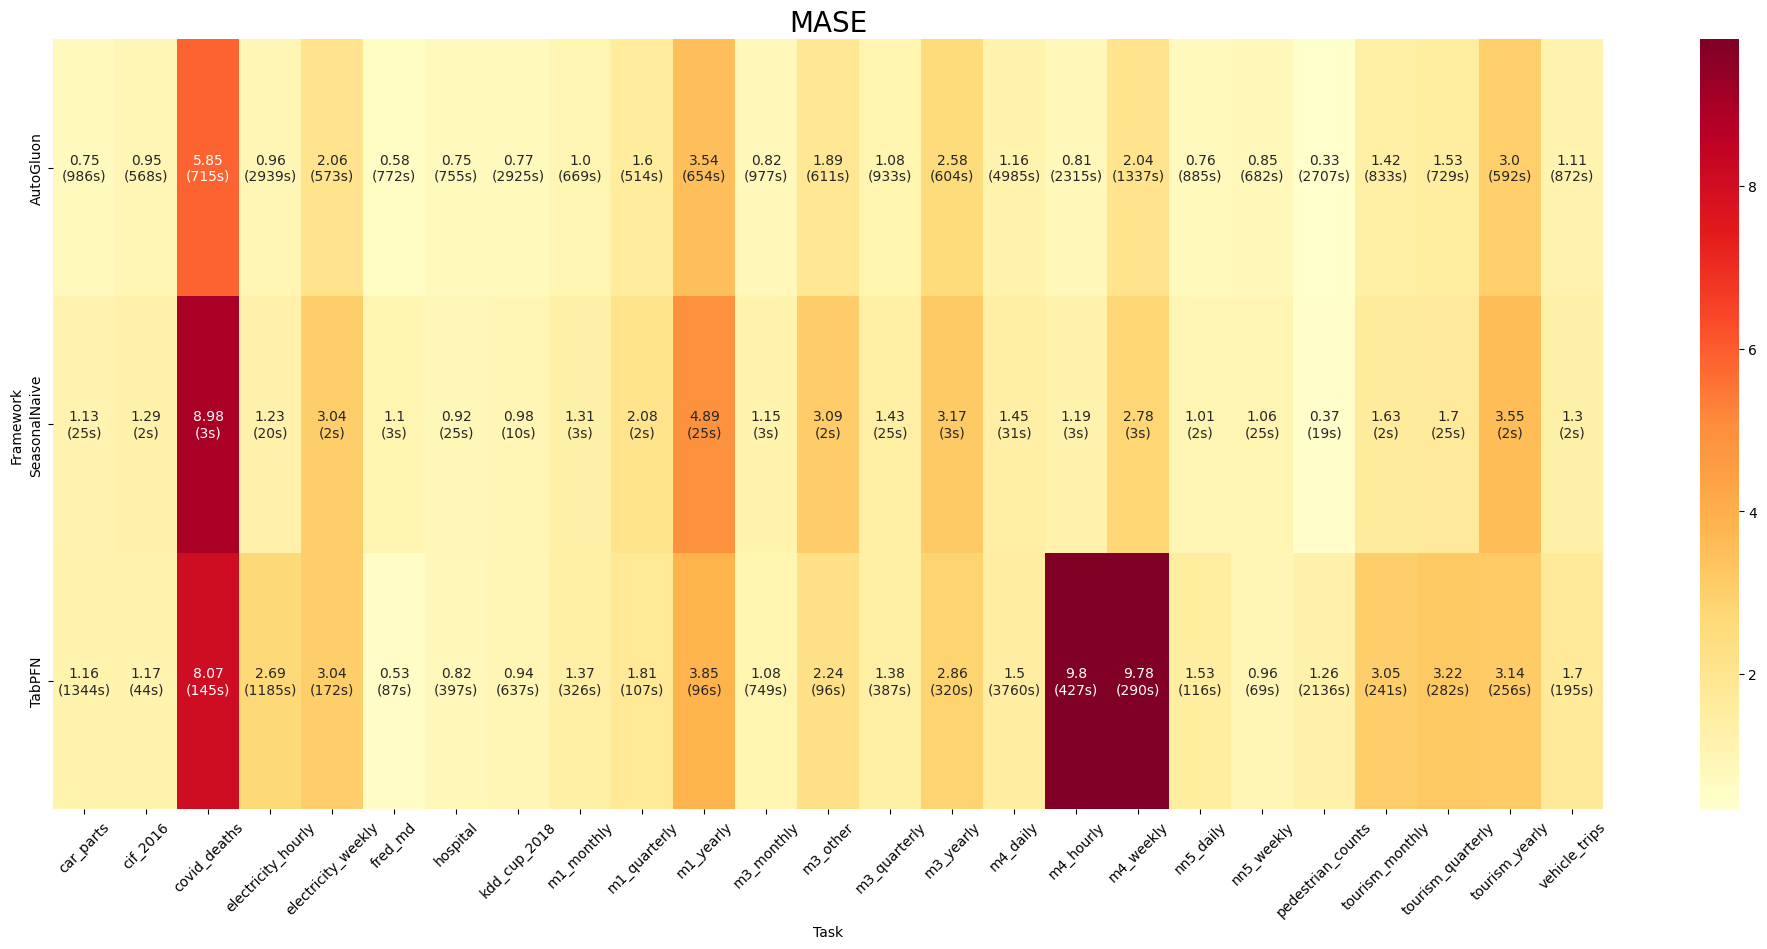

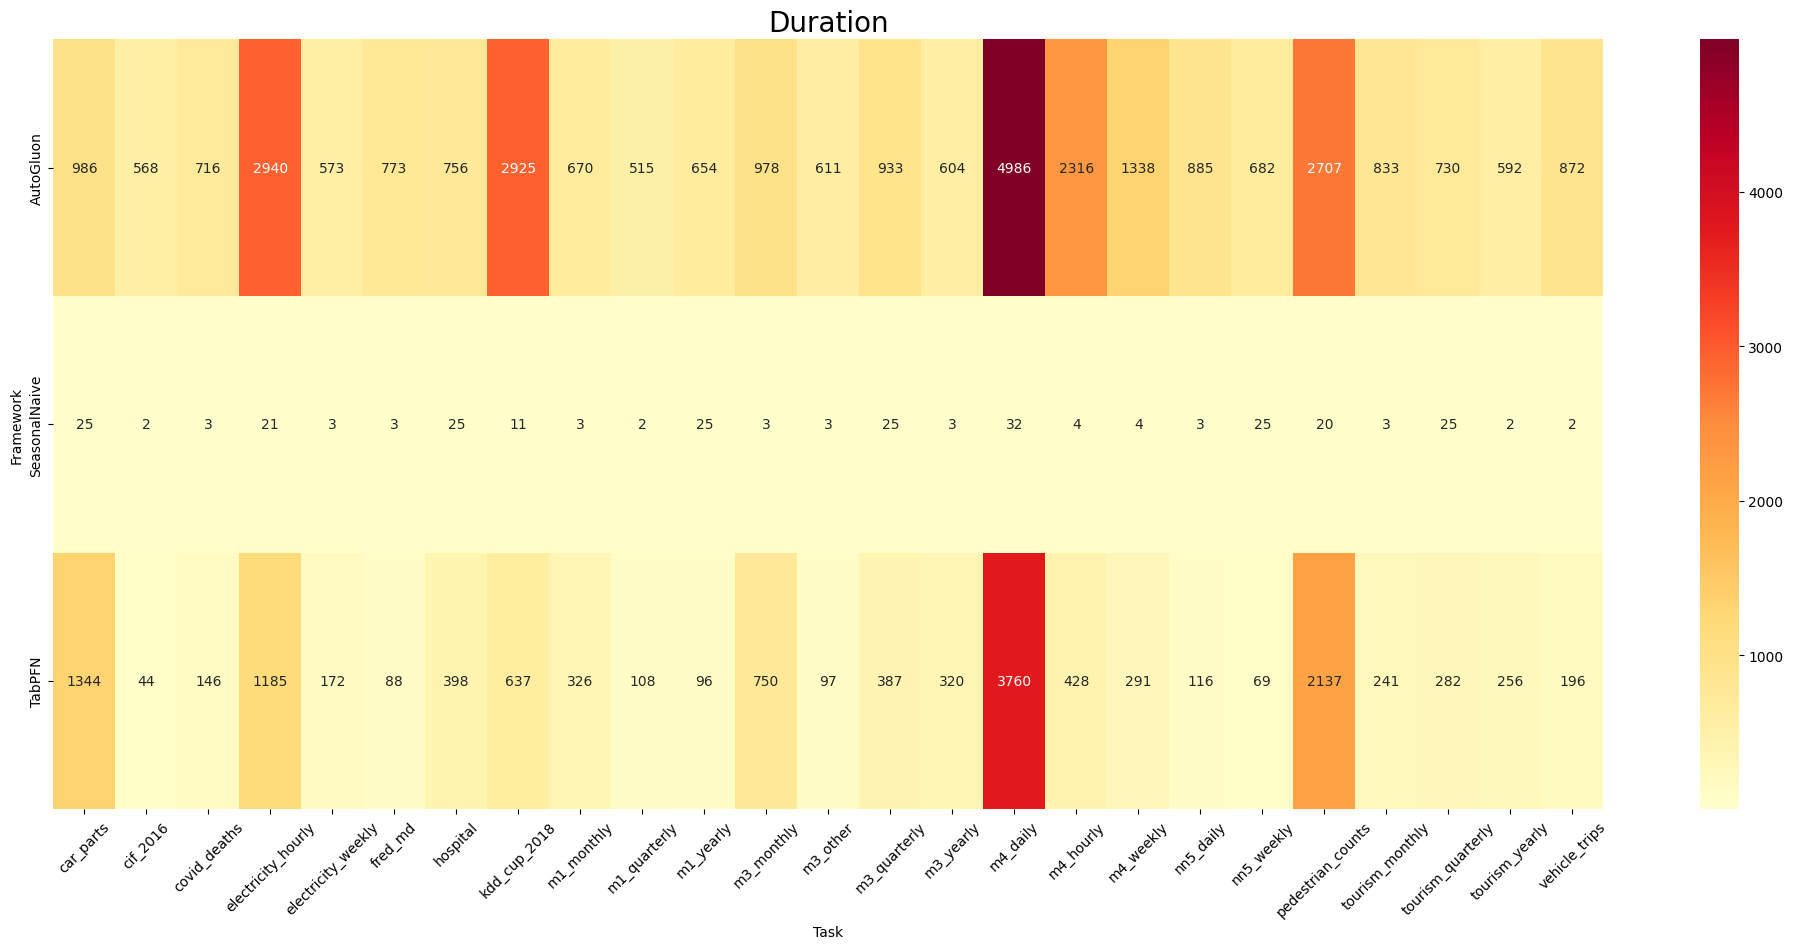

In [43]:
# Create Pivot tables for plotting
df_mase_pivot = df_all_runs.pivot(index='framework', columns='task', values='mase')

# Customized annotation (each cell should be value of mase and total duration as a subtext)
df_duration_pivot = df_all_runs.pivot(index='framework', columns='task', values='duration')
df_mase_annot = df_mase_pivot.round(2).astype(str) + "\n(" + df_duration_pivot.fillna(-1).astype(int).astype(str) + "s)"


plot_heatmap(df_mase_pivot, "MASE", "Task", "Framework", annot=df_mase_annot, annot_format="s")
plot_heatmap(df_duration_pivot, "Duration", "Task", "Framework")


### Normalized MASE (for Point Forecasting)

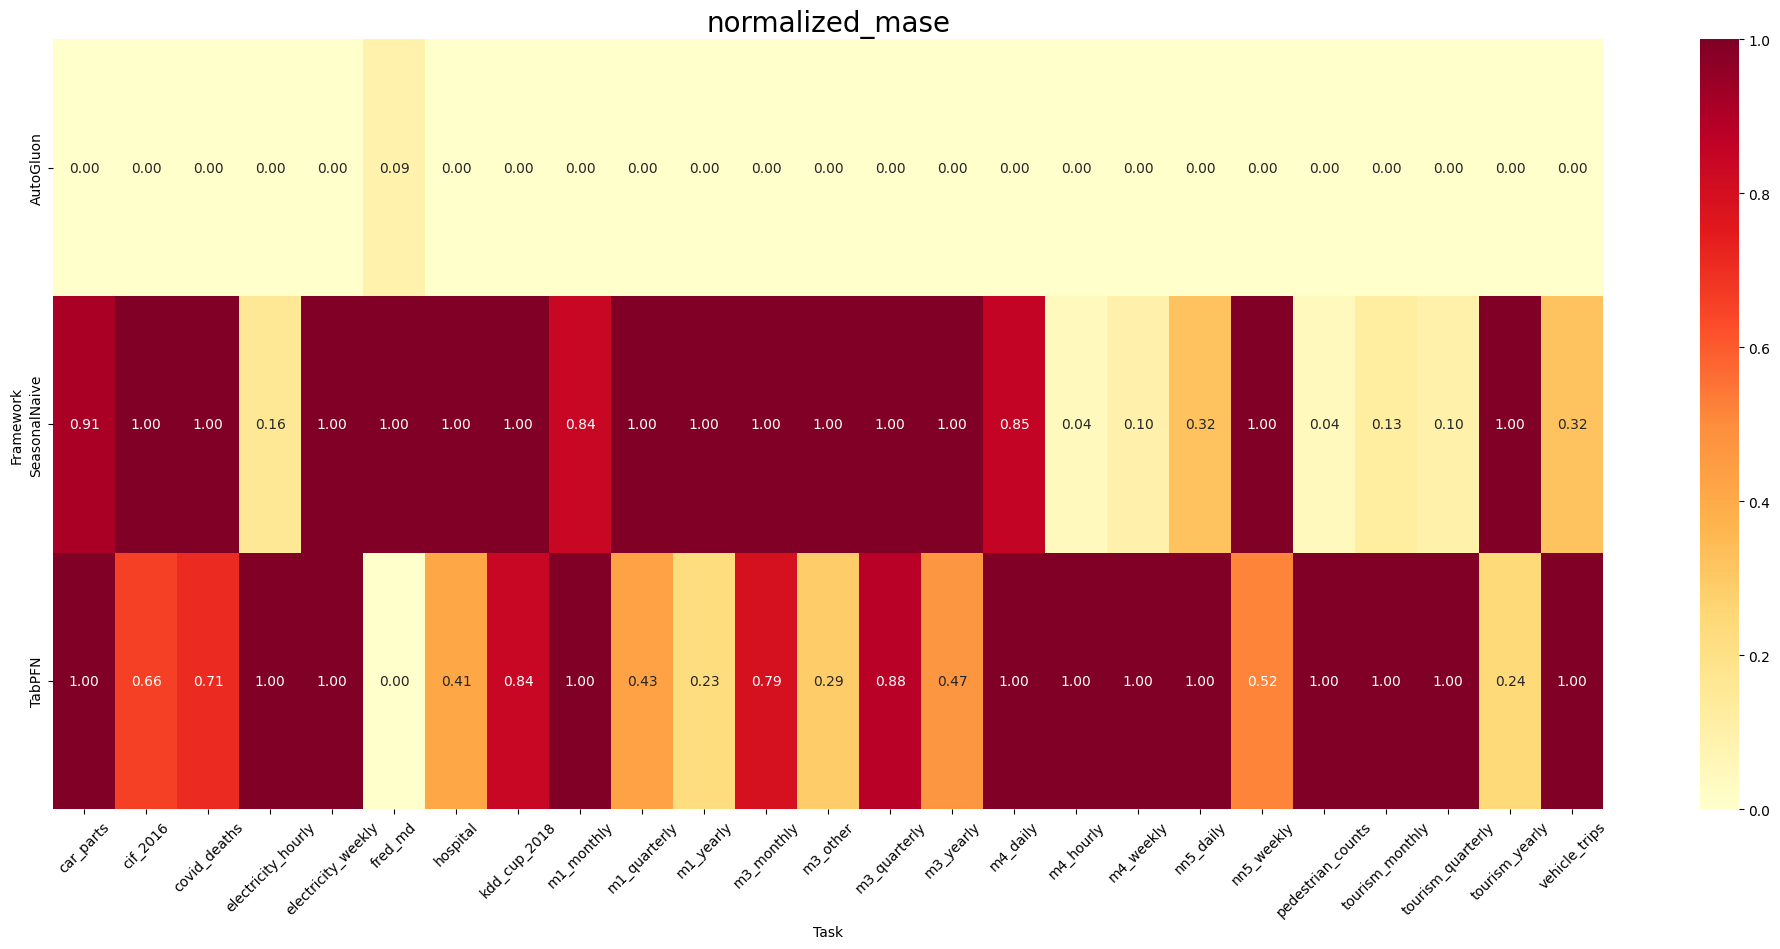

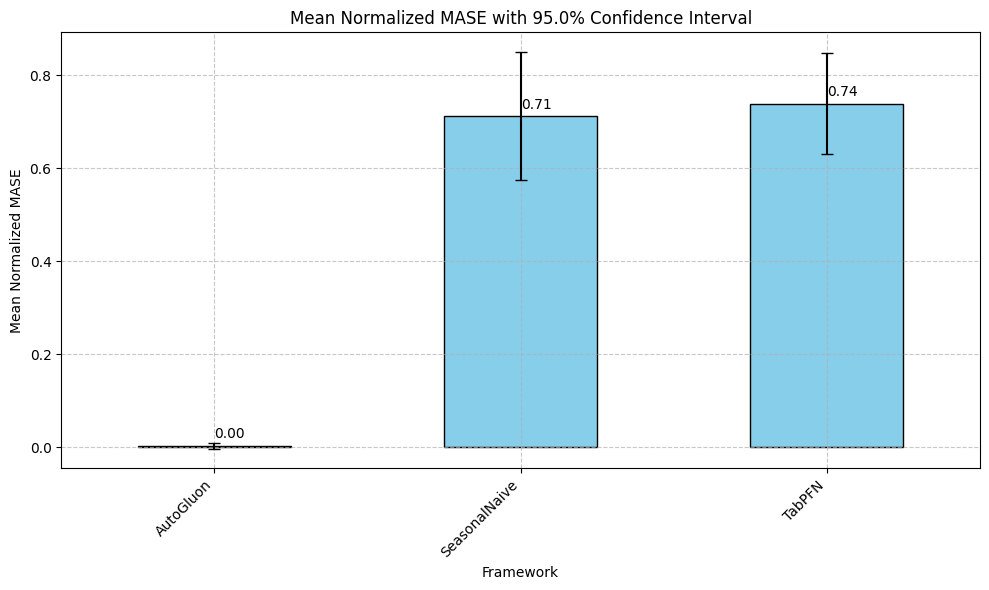

In [44]:
import numpy as np
from scipy.stats import t

df_norm_mase_pivot = df_all_runs.pivot(index='framework', columns='task', values='normalized_mase')
plot_heatmap(df_norm_mase_pivot, "normalized_mase", "Task", "Framework", annot_format=".2f")

def plot_mean_and_confidence_interval(df_pivot, confidence_level=0.95):
    mean_norm_mase = df_pivot.mean(axis=1)
    std_norm_mase = df_pivot.std(axis=1)
    confidence_interval = t.ppf(confidence_level, df_pivot.shape[1] - 1) * (std_norm_mase / np.sqrt(df_pivot.shape[1]))
    
    # Plot the mean and confidence interval
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = mean_norm_mase.plot(kind='bar', yerr=confidence_interval, ax=ax, capsize=4, color='skyblue', edgecolor='black')

    # Add value annotations on the bars
    for bar in bars.patches:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points", 
                    ha='left', va='bottom')

    # Customize the plot
    ax.set_title(f'Mean Normalized MASE with {confidence_level * 100}% Confidence Interval')
    ax.set_xlabel('Framework')
    ax.set_ylabel('Mean Normalized MASE')
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

confidence_level = 0.95
plot_mean_and_confidence_interval(df_norm_mase_pivot, confidence_level)


### Aggregated Metrics (for Point Forecasting)

In [45]:
calculate_framework_metrics(df_norm_mase_pivot)

,average_rescaled_mase,average_rank,champion
framework,,,
AutoGluon,0.003698,1.04,24
SeasonalNaive,0.712378,2.52,0
TabPFN,0.738793,2.44,1
